In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [39]:
class NN:
    def __init__(self, layers=None, activations=None, learning_rate=0.01):
        self.layers = layers or [100, 50, 1]
        self.activations = activations or ['relu', 'relu', 'linear']
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.history = {'loss': [], 'mae': [], 'mse': [], 'accuracy': []}


        for i in range(len(self.layers) - 1):

            if i < len(self.activations) and self.activations[i] == 'relu':
                limit = np.sqrt(2.0 / self.layers[i])
            else:
                limit = np.sqrt(6.0 / (self.layers[i] + self.layers[i+1]))

            w = np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1]))
            b = np.zeros((1, self.layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def _activation(self, x, activation):
        if activation == 'relu':
            return np.maximum(0.01 * x, x)
        elif activation == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation == 'linear':
            return x

    def _activation_der(self, x, activation):
        if activation == 'relu':
            return np.where(x > 0, 1.0, 0.01)
        elif activation == 'sigmoid':
            sig = self._activation(x, 'sigmoid')
            return sig * (1 - sig)
        elif activation == 'linear':
            return np.ones_like(x)

    def forward(self, X):
        self.a = [X]
        self.z = []

        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            a = self._activation(z, self.activations[i])
            self.a.append(a)

        return self.a[-1]

    def comp_loss(self, output, y, activation):
        m = y.shape[0]

        if activation == 'linear':
            loss = np.mean((output - y) ** 2)
        elif activation == 'sigmoid':
            epsilon = 1e-8
            output = np.clip(output, epsilon, 1 - epsilon)
            loss = -np.mean(y * np.log(output) + (1 - y) * np.log(1 - output))
        else:
            loss = np.mean((output - y) ** 2)

        return loss

    def backward(self, X, y, output):
        m = X.shape[0]

        dW = [np.zeros_like(w) for w in self.weights]
        dB = [np.zeros_like(b) for b in self.biases]


        if self.activations[-1] == 'linear':
            delta = 2 * (output - y) / m
        elif self.activations[-1] == 'sigmoid':
            epsilon = 1e-8
            output = np.clip(output, epsilon, 1 - epsilon)
            delta = (output - y) / m
        else:
            delta = 2 * (output - y) / m

        for i in range(len(self.weights)-1, -1, -1):
            dW[i] = np.dot(self.a[i].T, delta)
            dB[i] = np.sum(delta, axis=0, keepdims=True)

            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * \
                       self._activation_der(self.z[i-1], self.activations[i-1])

        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * dW[i]
            self.biases[i] -= self.learning_rate * dB[i]

    def fit(self, X, y, epochs=50, batch_size=32, validation_data=None, verbose=True):

        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values.reshape(-1, 1)
        else:
            y = y.reshape(-1, 1)

        self.scaler_X = StandardScaler()
        X = self.scaler_X.fit_transform(X)

        if self.activations[-1] == 'linear':
            self.scaler_y = StandardScaler()
            y = self.scaler_y.fit_transform(y)

        n_samples = X.shape[0]

        for epoch in range(epochs):

            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            batches = 0

            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]


                output = self.forward(X_batch)

                loss = self.comp_loss(output, y_batch, self.activations[-1])

                self.backward(X_batch, y_batch, output)

                epoch_loss += loss
                batches += 1

            epoch_loss /= batches
            self.history['loss'].append(epoch_loss)

            if validation_data is not None:
                X_val, y_val = validation_data
                val_pred = self.predict(X_val)

                if self.activations[-1] == 'linear':
                    mae = mean_absolute_error(y_val, val_pred)
                    mse = mean_squared_error(y_val, val_pred)
                    self.history['mae'].append(mae)
                    self.history['mse'].append(mse)

                    if verbose and epoch % 10 == 0:
                        print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Val MAE: {mae:.4f}")
                else:
                    val_pred_binary = (val_pred > 0.5).astype(int)
                    accuracy = accuracy_score(y_val, val_pred_binary)
                    self.history['accuracy'].append(accuracy)

                    if verbose and epoch % 10 == 0:
                        print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")
            elif verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

    def predict(self, X):

        if isinstance(X, pd.DataFrame):
            X = X.values

        X = self.scaler_X.transform(X)
        output = self.forward(X)

        if self.activations[-1] == 'linear':
            output = self.scaler_y.inverse_transform(output)

        return output.flatten()

    def predict_prob(self, X):
        if self.activations[-1] != 'sigmoid':
            raise ValueError("predict_prob available only for classification models")
        return self.predict(X)

    def evaluate(self, X, y):

        predictions = self.predict(X)

        if self.activations[-1] == 'linear':
            mae = mean_absolute_error(y, predictions)
            mse = mean_squared_error(y, predictions)
            return {'MAE': mae, 'MSE': mse}
        else:
            predictions_binary = (predictions > 0.5).astype(int)
            accuracy = accuracy_score(y, predictions_binary)
            return {'Accuracy': accuracy}


In [40]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):

        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y, method='gradient'):

        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.values

        y_ = np.where(y <= 0, -1, 1)

        n_samples, n_features = X.shape

        if method == 'gradient':
            self._fit_gradient(X, y_, n_samples, n_features)
        elif method == 'analytical':
            self._fit_analytical(X, y_, n_samples, n_features)

    def _fit_gradient(self, X, y, n_samples, n_features):

        self.w = np.zeros(n_features)
        self.b = 0


        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1

                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def _fit_analytical(self, X, y, n_samples, n_features):

        self.scaler = StandardScaler()
        X = self.scaler.fit_transform(X)

        X_with_bias = np.c_[np.ones(n_samples), X]
        y = y.reshape(-1, 1)

        identity = np.eye(n_features + 1)
        identity[0, 0] = 0

        self.theta = np.linalg.pinv(X_with_bias.T @ X_with_bias +
                                  self.lambda_param * identity) @ X_with_bias.T @ y

        self.b = self.theta[0]
        self.w = self.theta[1:].flatten()

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values

        if hasattr(self, 'scaler'):
            X = self.scaler.transform(X)

        approximation = np.dot(X, self.w) - self.b
        return np.sign(approximation)

    def evaluate(self, X, y):
        predictions = self.predict(X)
        y_binary = np.where(y <= 0, -1, 1)

        accuracy = np.mean(predictions == y_binary)

        true_pos = np.sum((predictions == 1) & (y_binary == 1))
        false_pos = np.sum((predictions == 1) & (y_binary == -1))
        false_neg = np.sum((predictions == -1) & (y_binary == 1))

        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

In [41]:
def plot_training_history(history, model_type):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history['loss'])
    plt.title(f'{model_type} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    if model_type == 'Regression':
        plt.subplot(1, 3, 2)
        plt.plot(history['mae'])
        plt.title('Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        plt.plot(history['mse'])
        plt.title('Validation MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.grid(True)
    else:
        plt.subplot(1, 3, 2)
        plt.plot(history['accuracy'])
        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)

    plt.tight_layout()
    plt.show()



Dataset shape: (10000, 17)

Columns: ['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors', 'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'price']

Target variable 'price' statistics:
Min: 10313.50, Max: 10006771.20
Mean: 4993447.53, Median: 5016180.30

Classification target distribution:
price
1    5000
0    5000
Name: count, dtype: int64
Price threshold: 5016180.30

Data splits:
Regression - Train: (8000, 16), Test: (2000, 16)
Classification - Train: (8000, 16), Test: (2000, 16)
Регрессия 
Epoch 0, Loss: 0.8941, Val MAE: 2142834.2197
Epoch 10, Loss: 0.0439, Val MAE: 479043.5025
Epoch 20, Loss: 0.0259, Val MAE: 374783.2247
Epoch 30, Loss: 0.0189, Val MAE: 324031.4199
Epoch 40, Loss: 0.0152, Val MAE: 294006.9653

Regression Results:
MAE: 275999.86
MSE: 121789212990.99
RMSE: 348983.11


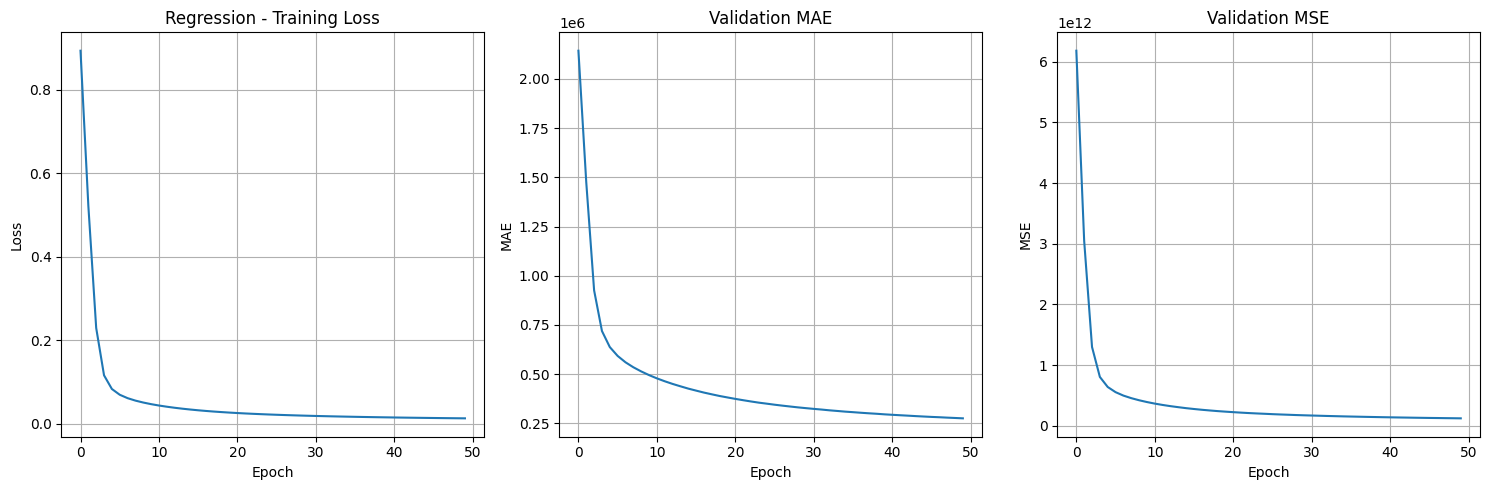

Классификация
Epoch 0, Loss: 0.5771, Val Accuracy: 0.9210
Epoch 10, Loss: 0.0411, Val Accuracy: 0.9875
Epoch 20, Loss: 0.0214, Val Accuracy: 0.9905
Epoch 30, Loss: 0.0128, Val Accuracy: 0.9920
Epoch 40, Loss: 0.0079, Val Accuracy: 0.9910

Classification Results:
Accuracy: 0.9915


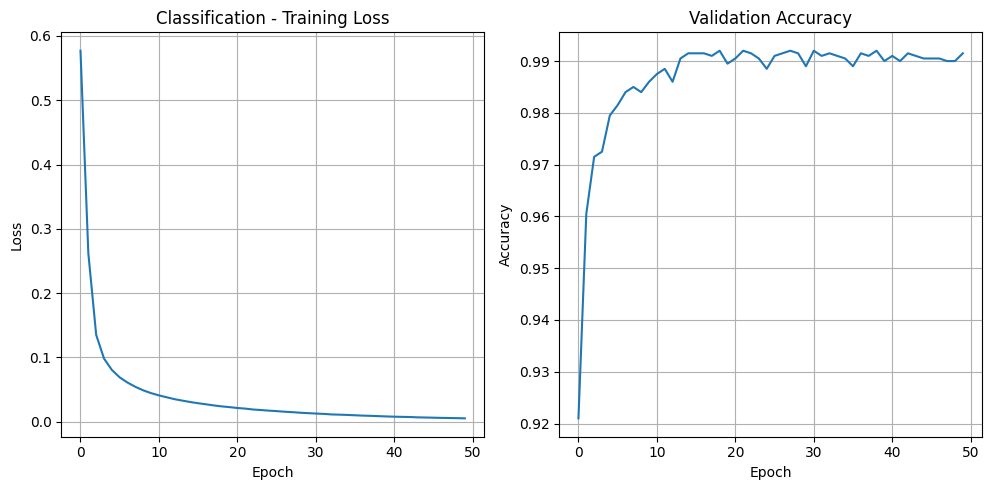

Метод опорных векторов
accuracy: 0.9900
precision: 0.9893
recall: 0.9912
f1_score: 0.9902
accuracy: 0.9940
precision: 0.9884
recall: 1.0000
f1_score: 0.9942


In [42]:
def demo_paris_housing_complete():

    data = pd.read_csv('ParisHousing.csv')
    print("Dataset shape:", data.shape)
    print("\nColumns:", data.columns.tolist())
    print(f"\nTarget variable 'price' statistics:")
    print(f"Min: {data['price'].min():.2f}, Max: {data['price'].max():.2f}")
    print(f"Mean: {data['price'].mean():.2f}, Median: {data['price'].median():.2f}")

    X = data.drop('price', axis=1)
    y = data['price']

    price_threshold = y.median()
    y_class = (y > price_threshold).astype(int)

    print(f"\nClassification target distribution:")
    print(y_class.value_counts())
    print(f"Price threshold: {price_threshold:.2f}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_class, test_size=0.2, random_state=42)

    print(f"\nData splits:")
    print(f"Regression - Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Classification - Train: {X_train_cls.shape}, Test: {X_test_cls.shape}")


    print("Регрессия ")


    nn_reg = NN(
        layers=[X.shape[1], 128, 64, 32, 1],
        activations=['relu', 'relu', 'relu', 'linear'],
        learning_rate=0.001
    )

    nn_reg.fit(X_train, y_train, epochs=50, batch_size=32,
               validation_data=(X_test, y_test), verbose=True)

    nn_reg_metrics = nn_reg.evaluate(X_test, y_test)
    print(f"\nRegression Results:")
    print(f"MAE: {nn_reg_metrics['MAE']:.2f}")
    print(f"MSE: {nn_reg_metrics['MSE']:.2f}")
    print(f"RMSE: {np.sqrt(nn_reg_metrics['MSE']):.2f}")


    plot_training_history(nn_reg.history, 'Regression')



    print("Классификация")


    nn_cls = NN(
        layers=[X.shape[1], 128, 64, 32, 1],
        activations=['relu', 'relu', 'relu', 'sigmoid'],
        learning_rate=0.01
    )

    nn_cls.fit(X_train_cls, y_train_cls, epochs=50, batch_size=32,
               validation_data=(X_test_cls, y_test_cls), verbose=True)

    nn_cls_metrics = nn_cls.evaluate(X_test_cls, y_test_cls)
    print(f"\nClassification Results:")
    print(f"Accuracy: {nn_cls_metrics['Accuracy']:.4f}")

    plot_training_history(nn_cls.history, 'Classification')

    print("Метод опорных векторов")


    svm_gradient = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=1000)
    svm_gradient.fit(X_train_cls, y_train_cls, method='gradient')

    svm_gradient_metrics = svm_gradient.evaluate(X_test_cls, y_test_cls)
    for metric, value in svm_gradient_metrics.items():
        print(f"{metric}: {value:.4f}")

    svm_analytical = SVM(lambda_param=0.01)
    svm_analytical.fit(X_train_cls, y_train_cls, method='analytical')

    svm_analytical_metrics = svm_analytical.evaluate(X_test_cls, y_test_cls)
    for metric, value in svm_analytical_metrics.items():
        print(f"{metric}: {value:.4f}")

    return {
        'nn_regression': nn_reg,
        'nn_classification': nn_cls,
        'svm_gradient': svm_gradient,
        'svm_analytical': svm_analytical,
        'data': {
            'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test,
            'X_train_cls': X_train_cls, 'X_test_cls': X_test_cls,
            'y_train_cls': y_train_cls, 'y_test_cls': y_test_cls
        }
    }


if __name__ == "__main__":
        models = demo_paris_housing_complete()